# SEQM Guide

SEQM is a library to perform the whole pipeline of training and testing probabilistic models for sistematic trading.

When modelling data to get predictive signals and make decisions based on it we have two problems:
- Finding and edge (something that can be predictive of a investment - a return)
- How to use that _signal_

The objective of this program is to apply optimal betting to the predictive distribution of the trained model, eliminating the need to work around on what to do with the signals; a classic example would be the case where someone builds a linear regression to predict some returns. Now we can come up with several ways to _test_ the model as a investment - we can make a binary bet to go long[short] when the expected value is positive[negative]. If one is not happy then maybe we will go into computing some measure of dispersion changing over time and adjust to some target volatility. Actually none of these options is optimal since, in this regression setup, the optimal decision is to make a bet proportional to the expected value (in a regression it is just the mean that changes, second moment is constant).

Each model implemented always outputs a predictive distribution that can be used to make the bet - we try to have a diverse set of models to capture all types of effects that make sense in a trading setup.

As in any statistical learning problem, the objective is to compute a measure of future performance. The program does this by cross-validation: on a given subset of data the model is learned and then applied as a investment strategy in other subset. Also, we can change the subsets where we choose the training data from - this will yield different parameters (we expect not that different) and then we will have a different performance on the test set. This way we can simulate many possible strategy returns, illustrating the variablity with respect to the training data.

##### Note
All the examples in the guide are made with synthethic data.


### Install
Download and run __pip__ __install__ __.__ on the directory where __setup.py__ is present.

## Linear Regression Example

The following code illustrates how can one make a strategy based on a linear regression. The explanations are on the code.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seqm
plt.style.use('dark_background')

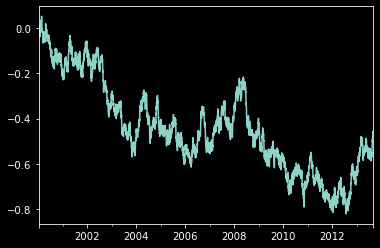

In [32]:
# Create a dataset
# We need a dataframe with columns starting with x and y
# x's are features
# y's are returns

# in this example we will make an autogressive process (which can be modelled with a linear regression)
n = 5000 # number of points
s = 0.01 # standard deviation per period - 1% a day here
a = -0.075 # autoregression

y = np.zeros(n)
for i in range(1, n):
    y[i] = a*y[i-1] + np.random.normal(0, s)
    
data = pd.DataFrame(y, columns = ['y'], index = pd.date_range('2000-01-01', periods = n, freq = 'D'))
# now data contains out sequence of returns
# want to make a model using the previous value
# let us create the feature by lagging y
data['x'] = data['y'].shift(1)
data = data.dropna()
data
# NOTE
# - all uses of seqm start by the user creating its own dataset with the features considered releant
# - remember that we invest on y's that should be returns!
# - do not leave price type variables on it
# since we have returns on y, we could plot the "price" path that gave origin to it
np.cumsum(data['y']).plot()
plt.show()

In [33]:
# having a dataset, let us go on to the recipe on how to use the seqm

In [34]:
# 1 - create seqm.Dataset object
# this object can contains several datasets
# in this example we only have one dataset and so it is just a single dict
# we have a key 'data' choosen arbitrarily and its value is our dataframe data
seqm_dataset = seqm.Dataset({'data' : data})

In [35]:
# 2 - create a seqm.ModelPipes
# now we will create a model pipeline to apply to that data

# initialize 
model_pipes = seqm.ModelPipes()
#
# create a model
# in this case we want the model to be a linear regression
# in seqm this is called a ConditionalGaussian
model = seqm.ConditionalGaussian(kelly_std=2, max_w=1)
# create a pipe (which in this simple case, only contains previous model) 
model_pipe = seqm.ModelPipe(model = model)

# store pipe in pipes by associating it to the key that we defined in 'data'
model_pipes['data'] = model_pipe

# NOTE
# as should be more or less obvious, just like we could include more datasets when we 
# build the variable seqm_dataset, here we should add the model pipe to be applied
# to each dataset (that is why it is called ModelPipes and the single one ModelPipe)

In [36]:
# 3 - now we can go into the strategy training and testing
# basically, our seqm_dataset object has a method called cvbt which means
# cross validation back test
# we will do the cvbt with the model pipes that we defined above
# the output is the strategy returns paths (with some more info)
paths = seqm_dataset.cvbt(
                        model_pipes = model_pipes, # model pipes for the dataset
                        k_folds = 5, # number of cross validation folds
                        seq_path = False,  # preserve time order of data (check blog)
                        start_fold = 0, # used when seq_path = True
                        n_paths = 10, # number of backtest paths to be generated
                        burn_fraction = 0.1, # fraction of training data to be burned to create variability
                        min_burn_points = 3 # min number of points to left out near the testing set 
                        )

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


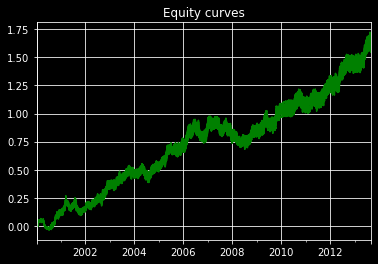

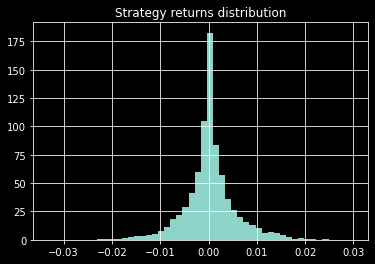

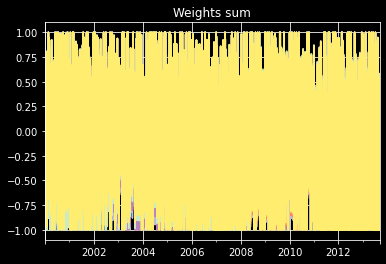

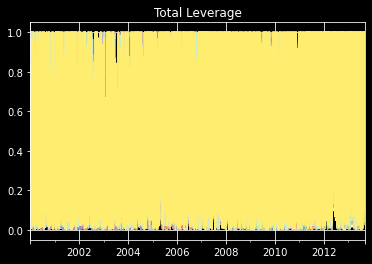


** ACCEPT STRATEGY **


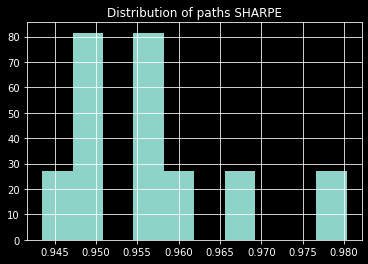

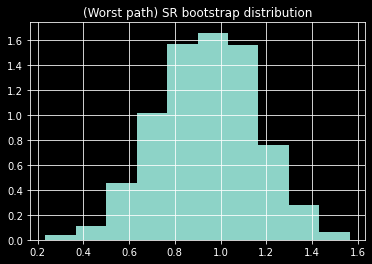


** PERFORMANCE SUMMARY **

Return:  0.08110274199302961
Standard deviation:  0.08477742665233247
Sharpe:  0.9566549162388174



In [37]:
# 4 - process results
seqm.post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                )
# now the outputs (top to bottom)
# 1 - strategy equity curves
# 2 - returns distribution
# 3 - weights over time (if we have more y's we would have more plots)
# 4 - total leverage (if we have many y's it is the sum of modulus of weights)
# 5 - distribution of sharpe ratio based on paths
# 6 - picking up the path with the worst sharpe ratio, we make a bootstrap estimate
# of sharpe to assess the probability that the sharpe is positive. If there are no
# bootstrap samples with negative sharpe we conclude that the strategy can be accepted
# this is usefull to control for multiple testing. Maybe can be quite restrictive.

## Multiple Datasets

In this example, let us test multiple models on multiple datasets to test a portfolio of individual models.

In [39]:
# Create datasets
# Each dataset follows the same structure as above

# in this example we will make two autogressive processes

# dataset 1
n = 5000 # number of points
s = 0.01 # standard deviation per period - 1% a day here
a = -0.075 # autoregression
# simulate
y = np.zeros(n)
for i in range(1, n):
    y[i] = a*y[i-1] + np.random.normal(0, s)    
index = pd.date_range('2000-01-01', periods = n, freq = 'D')
data1 = pd.DataFrame(y, columns = ['y'], index = index)
data1['x'] = data1['y'].shift(1)
data1 = data1.dropna()
print(data1)

# dataset 2
m = 2500 # number of points
s = 0.005 # standard deviation per period - 1% a day here
a = 0.075 # autoregression
# simulate
y = np.zeros(m)
for i in range(1, m):
    y[i] = a*y[i-1] + np.random.normal(0, s)    
data2 = pd.DataFrame(y, columns = ['y'], index = index[-m:])
data2['x'] = data2['y'].shift(1)
data2 = data2.dropna()
print(data2)
# notice how both of them have different dates, which does not matter
# since the models are individual

                   y         x
2000-01-02 -0.000396  0.000000
2000-01-03 -0.001597 -0.000396
2000-01-04  0.012772 -0.001597
2000-01-05  0.004334  0.012772
2000-01-06  0.004725  0.004334
...              ...       ...
2013-09-04  0.005902 -0.000449
2013-09-05  0.007760  0.005902
2013-09-06  0.004666  0.007760
2013-09-07 -0.010864  0.004666
2013-09-08  0.013193 -0.010864

[4999 rows x 2 columns]
                   y         x
2006-11-06 -0.002623  0.000000
2006-11-07  0.002047 -0.002623
2006-11-08 -0.006926  0.002047
2006-11-09  0.000798 -0.006926
2006-11-10  0.006648  0.000798
...              ...       ...
2013-09-04  0.006572  0.006197
2013-09-05 -0.001108  0.006572
2013-09-06 -0.000398 -0.001108
2013-09-07  0.001387 -0.000398
2013-09-08  0.005262  0.001387

[2499 rows x 2 columns]


In [40]:
# 1 - create seqm.Dataset object
seqm_dataset = seqm.Dataset({'data1' : data1, 'data2' : data2})

In [43]:
# 2 - create a seqm.ModelPipes

# initialize 
model_pipes = seqm.ModelPipes()
#
# now we need to create a ModelPipe for each model
# also, we can add transforms to the data
# Each model is trained and tested individually but then we
# must decide on how to allocated to each strategy
# There are some built in methods and one of them is to allocate
# to each strategy in a inverse vol way (this is kind of a optimal solution
# if strategies are uncorrelated)
# this InvVolPwTransform will do nothing to the data where the model is trained
# but will compute the standard deviation of the training data and store it 
model = seqm.ConditionalGaussian(kelly_std=2, max_w=1)
model_pipe = seqm.ModelPipe(
                            x_transform = seqm.InvVolPwTransform(),
                            y_transform = seqm.InvVolPwTransform(),
                            model = model
                            )
model_pipes['data1'] = model_pipe

model = seqm.ConditionalGaussian(kelly_std=2, max_w=1)
model_pipe = seqm.ModelPipe(
                            x_transform = seqm.InvVolPwTransform(),
                            y_transform = seqm.InvVolPwTransform(),
                            model = model
                            )
model_pipes['data2'] = model_pipe


In [44]:
# 3 - now we can go into the strategy training and testing
paths = seqm_dataset.cvbt(
                        model_pipes = model_pipes, # model pipes for the dataset
                        k_folds = 5, # number of cross validation folds
                        seq_path = False,  # preserve time order of data (check blog)
                        start_fold = 0, # used when seq_path = True
                        n_paths = 10, # number of backtest paths to be generated
                        burn_fraction = 0.1, # fraction of training data to be burned to create variability
                        min_burn_points = 3 # min number of points to left out near the testing set 
                        )

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]


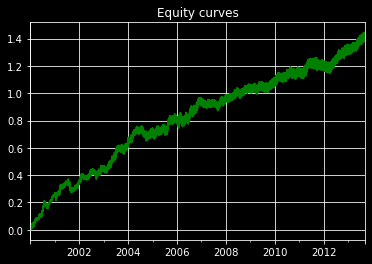

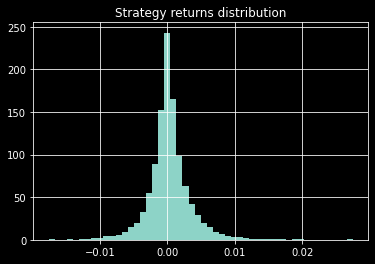

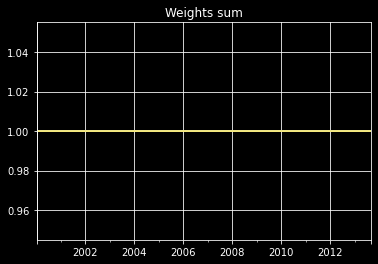

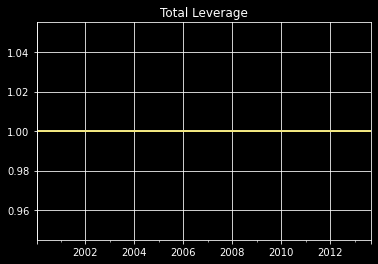

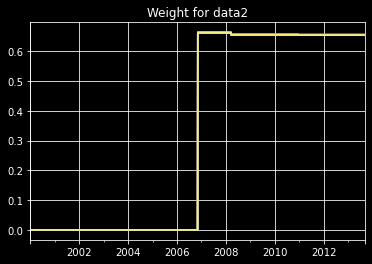

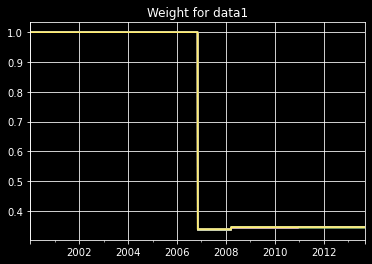

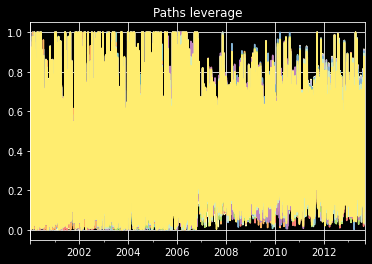

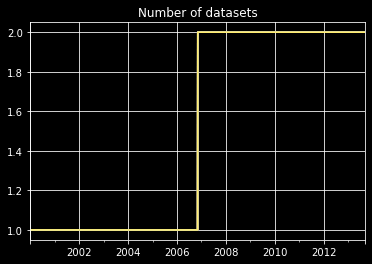


** ACCEPT STRATEGY **


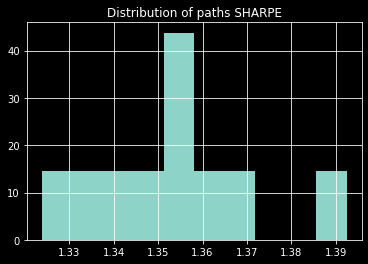

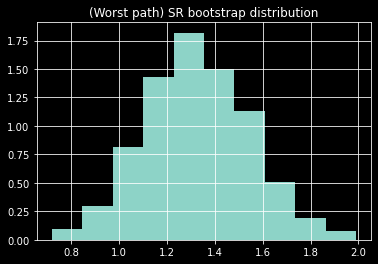


** PERFORMANCE SUMMARY **

Return:  0.07072185341362552
Standard deviation:  0.052263084836227644
Sharpe:  1.3531894191711136



In [45]:
# 4 - process results
# first let us post process the whole portfolio of strategies
seqm.portfolio_post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                view_weights = True, # view weights attributed to datasets in portfolio
                use_pw = True # use the portfolio weight computed with the applied transform
                              # in this case, it was the InvVolPwTransform
                )
# the plots are similar but now we can see the plots with
# weights for data1 and data2  
# notice that, since data1 starts earlier, for half the period it has a weight of 1
# because it is the only one
# after that, since data2 has a lower vol it has a higher weight

FOR DATA 1


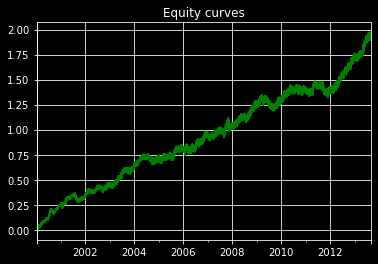

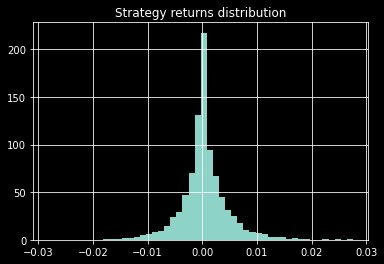

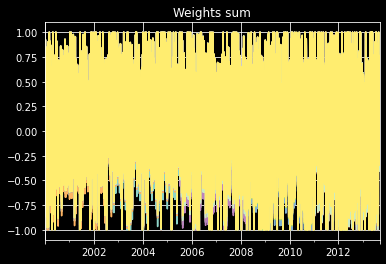

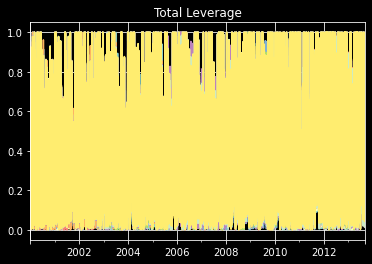


** ACCEPT STRATEGY **


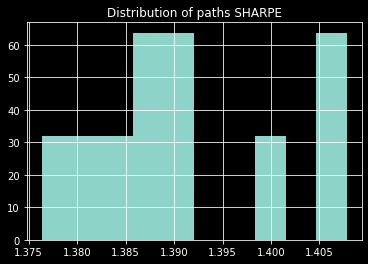

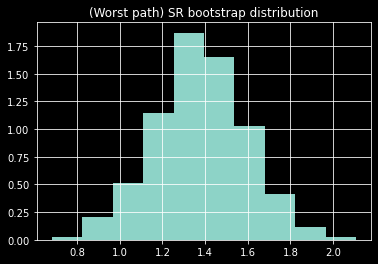


** PERFORMANCE SUMMARY **

Return:  0.096955513205382
Standard deviation:  0.06969878501619134
Sharpe:  1.3910646101342914

FOR DATA 2


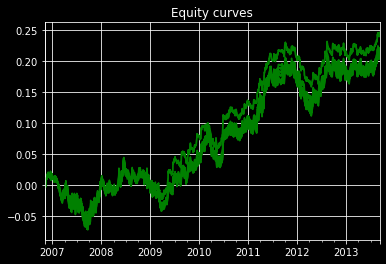

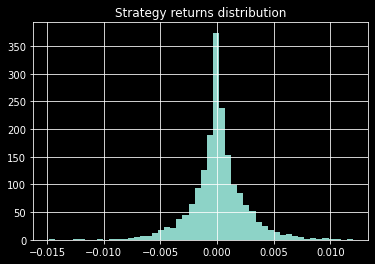

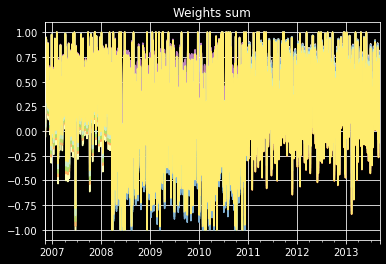

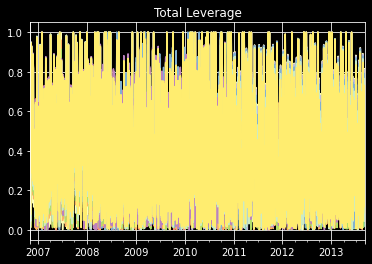


** REJECT STRATEGY **


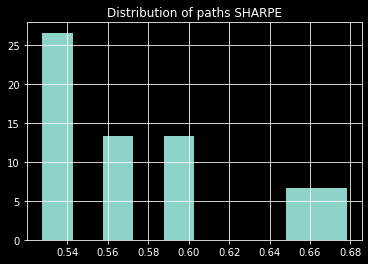

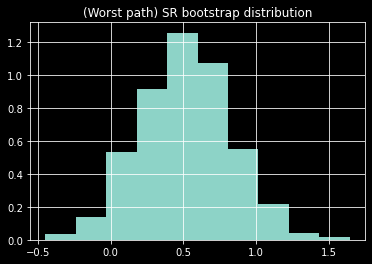


** PERFORMANCE SUMMARY **

Return:  0.022206870519087117
Standard deviation:  0.03854771163325687
Sharpe:  0.5760879071204901



In [47]:
# also, we can analyse the individual strategies with
print('FOR DATA 1')
seqm.post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                key = 'data1'
                )
print('FOR DATA 2')
seqm.post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                key = 'data2'
                )




## Multiple Features and Targets

What about if we want to invest in many securities at the same time with many features making the signal?

In [58]:
# Create a dataset

n = 5000 # number of points

# First let us create 3 random features
x = np.random.normal(0, 0.01, (n, 3))
# and now, let us have two investments y1 and y2 that depend on the features
# in a different manner
# allocate space
y = np.zeros((n,2))
# y1
s1 = 0.01
a1 = np.array([0.1, -0.2, 0])
y[:,0] = np.sum(x*a1,axis = 1) + np.random.normal(0, s1, n)
# y2
s2 = 0.02
a2 = np.array([0.2, 0, -0.1])
y[:,1] = np.sum(x*a2,axis = 1) + np.random.normal(0, s2, n)

# create dataset
index = pd.date_range('2000-01-01', periods = n, freq = 'D')
data = pd.DataFrame(np.hstack((x,y)), columns = ['x1','x2','x3','y1','y2'], index = index)
data

,x1,x2,x3,y1,y2
2000-01-01,0.004281,-0.011457,0.016580,0.010545,-0.050715
2000-01-02,0.003407,-0.018981,0.009290,-0.001319,-0.018081
2000-01-03,-0.018022,0.005185,-0.005034,0.006580,0.014918
2000-01-04,-0.011905,0.002775,0.009776,0.001433,-0.020601
2000-01-05,-0.008380,-0.000462,0.000635,-0.005169,-0.015030
...,...,...,...,...,...
2013-09-04,-0.002915,-0.007506,0.011888,-0.002896,0.036162
2013-09-05,0.002772,0.002805,0.003345,0.011818,0.008089
2013-09-06,-0.005084,0.005778,-0.002172,-0.001401,-0.014051
2013-09-07,-0.006538,-0.009572,0.001920,-0.005372,-0.075582


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]


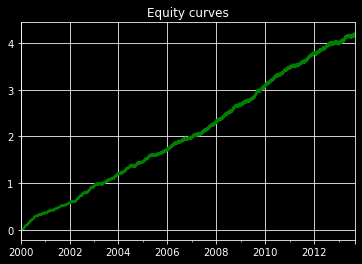

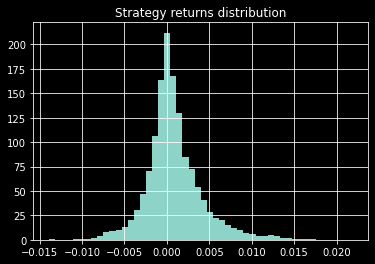

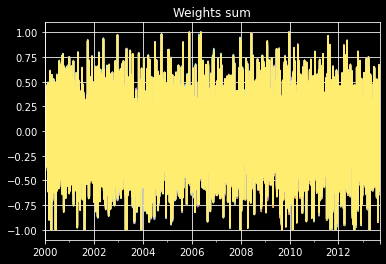

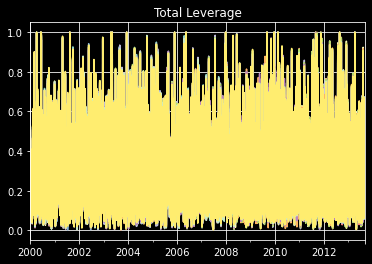

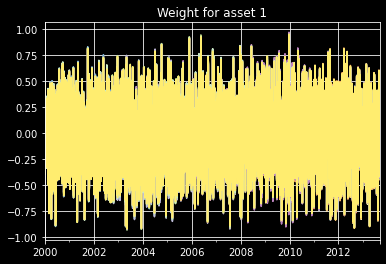

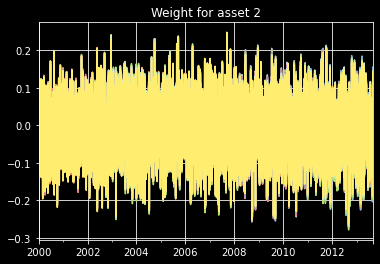


** ACCEPT STRATEGY **


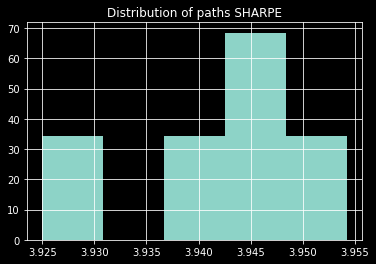

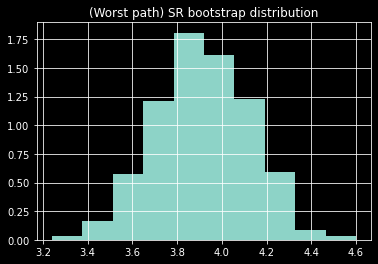


** PERFORMANCE SUMMARY **

Return:  0.2105360620815899
Standard deviation:  0.05340444151660387
Sharpe:  3.942294987133842



In [59]:
# now everyting is the same!
seqm_dataset = seqm.Dataset({'data' : data})

model_pipes = seqm.ModelPipes()
#
# create a model
# in this case we want the model to be a linear regression
# in seqm this is called a ConditionalGaussian
model = seqm.ConditionalGaussian(kelly_std=2, max_w=1)
# create a pipe (which in this simple case, only contains previous model) 
model_pipe = seqm.ModelPipe(model = model)

# store pipe in pipes by associating it to the key that we defined in 'data'
model_pipes['data'] = model_pipe


paths = seqm_dataset.cvbt(
                        model_pipes = model_pipes, # model pipes for the dataset
                        k_folds = 5, # number of cross validation folds
                        seq_path = False,  # preserve time order of data (check blog)
                        start_fold = 0, # used when seq_path = True
                        n_paths = 10, # number of backtest paths to be generated
                        burn_fraction = 0.1, # fraction of training data to be burned to create variability
                        min_burn_points = 3 # min number of points to left out near the testing set 
                        )


seqm.post_process(
                paths = paths, # previously generated paths 
                pct_fee = 0., # percentage fee
                seq_fees = False, # means that the fees are only computed on the weight change
                sr_mult = np.sqrt(250), # in this example, let us assume the data is daily
                n_boot = 1000, # number of bootstrap sample
                )                        